<a href="https://colab.research.google.com/github/JSiyangLi/funnel/blob/main/docs%20/examples/fi_lartillot_simulation_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FI Lartillot Simulation

In [19]:
import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.stats import norm
from jax.scipy.special import logsumexp
from jax import jit
import os
import jax
jax.config.update("jax_enable_x64", False)


OUTDIR = 'out_simulation'
if not os.path.exists(OUTDIR):
  os.makedirs(OUTDIR)

seed = random.PRNGKey(0)


@jit
def get_rngkey():
  return random.PRNGKey(random.randint(seed, (1,1), 0, 2147483647)[0][0])

@jit
def fi_ln_post(ref_samp, posterior_samples, r, sample_const):
  # posterior approximate
  diff_from_ref = (ref_samp - posterior_samples) * sample_const
  sin_diff = jnp.sin(r * diff_from_ref )
  integrand = sin_diff / (diff_from_ref)
  prod_res = jnp.nanprod(integrand, axis=1)
  sum_res = jnp.abs(jnp.nansum(prod_res))
  n_samp, n_dim = posterior_samples.shape
  const = 1 / (n_samp * jnp.pi**n_dim)
  return jnp.log(sum_res * const)


def fi_lnz_new(p, v, r, nsamples=int(1e4)):
  ref_samp = jnp.zeros(p)
  posterior_samples = simulate_posterior_samples(p, v, nsamples)
  ref_lnpri = log_prior(ref_samp)
  ref_lnl= log_like(ref_samp, p, v)

  # posterior approximate
  diff_from_ref = ref_samp - posterior_samples
  xmax = jnp.nanmax(diff_from_ref) # max diff from rows and cols
  sample_const =  (jnp.pi/xmax)
  approx_ln_post = fi_ln_post(ref_samp, posterior_samples, r, sample_const)

  return ref_lnpri + ref_lnl - approx_ln_post


def fi_lnz(p, v, r, nsamples=int(1e4)):
  ref_samp = jnp.zeros(p)
  posterior_samples = simulate_posterior_samples(p, v, nsamples)
  ref_lnpri = log_prior(ref_samp)
  ref_lnl= log_like(ref_samp, p, v)

  # posterior approximate
  sample_const =  1
  approx_ln_post = fi_ln_post(ref_samp, posterior_samples, r, sample_const)
  return ref_lnpri + ref_lnl - approx_ln_post


@jit
def lnl_const(p, v):
  return -(p / 2) * jnp.log(2 * jnp.pi * v)

@jit
def true_lnZ(p, v):
  return (p / 2) * jnp.log(v / (1 + v)) + lnl_const(p, v)

@jit
def log_like(theta, p, v):
  return -jnp.sum(theta**2 / (2 * v)) + lnl_const(p, v)

@jit
def log_prior(theta):
  return jnp.sum(norm.logpdf(theta, loc=0, scale=1))


def simulate_posterior_samples(p, v, nsamples):
  key = get_rngkey()
  mean = jnp.zeros(p)
  cov_matrix = v / (v + 1) * jnp.eye(p)
  samples = random.multivariate_normal(key, mean=mean, cov=cov_matrix, shape=(nsamples,))
  return samples



In [27]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-poster')
import numpy as np
plt.rcParams['figure.figsize'] = (5,4)

def plot_curves(p=1, v=1, nsamples=int(1e5)):
  rs = np.geomspace(1, int(1e6), 1000)
  fis = jnp.array([fi_lnz(p,v,r,nsamples) for r in rs]) - true_lnZ(p,v)
  fis_new = jnp.array([fi_lnz_new(p,v,r,nsamples) for r in rs]) - true_lnZ(p,v)
  plt.axhline(0, color='k')
  plt.semilogx(rs, fis, label='Original')
  plt.semilogx(rs, fis_new, label='Renate')
  plt.xlabel('R')
  plt.ylabel('Fi LnZ - True LnZ')
  plt.title(f'P={p}, v={v}, nsamp={nsamples:.0E}')
  plt.legend()

## PLOTS

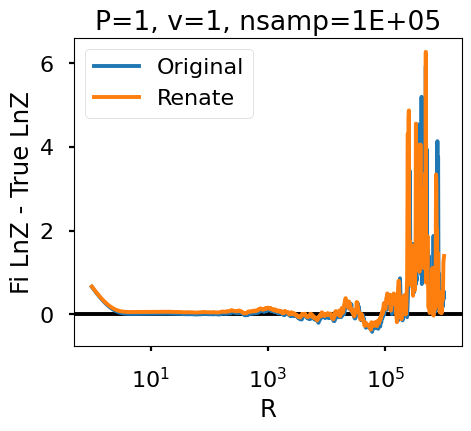

In [28]:
jax.config.update("jax_enable_x64", False)
plot_curves(p=1,v=1)

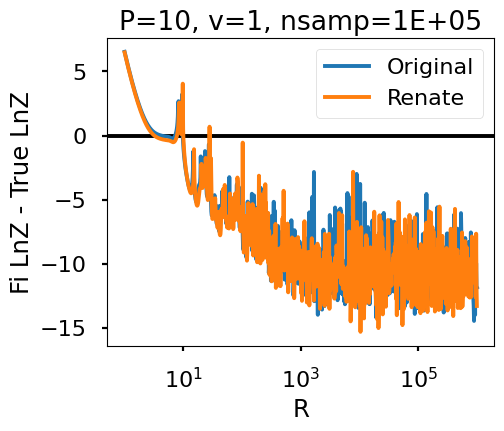

In [31]:
jax.config.update("jax_enable_x64", False)
plot_curves(p=10,v=1)

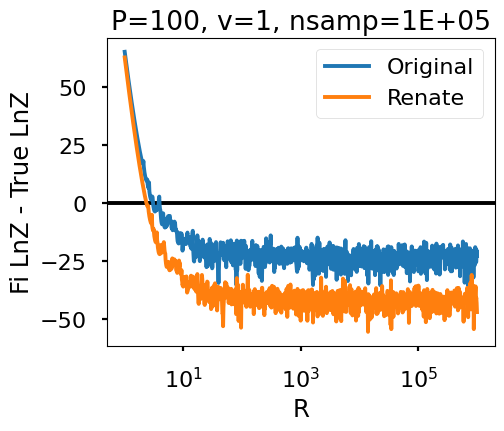

In [68]:
jax.config.update("jax_enable_x64", True)
plot_curves(p=100,v=1)

#### Serial

```
from tqdm import trange, tqdm
from scipy.stats import multivariate_normal, cauchy, norm
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd
from tqdm.auto import trange
from typing import Tuple

np.random.seed(0)

OUTDIR = 'out_simulation'
os.makedirs(OUTDIR, exist_ok=True)


import os


def fi_ln_evidence_np(
        posterior_samples: np.ndarray,
        ref_samp: np.array,
        r: float,
        ref_lnpri: float,
        ref_lnl: float,
):
    """
    Returns the approx log-evidence of some posterior samples (using a reference parameter value).
    The approximation is based on the 'density estimation' method described in
    [Rotiroti et al., 2018](https://link.springer.com/article/10.1007/s11222-022-10131-0).


    P_fi(theta_ref, R, nsamp) = (1/n*pi**ndim) Sum_nsamp Prod_nparm  [sin( R * (ref - samp_i))]/(ref - samp_i)

    :param posterior_samples:np.ndarray: Array of posterior samples [n_samples, n_dim]
    :param ref_samp:np.array: A reference parameter value [n_dim] (Not present in the posterior)
    :param r:float: A scaling factor
    :param ref_lnpri:float: The log of the reference prior
    :param ref_lnl:float: The log of the reference likelihood
    :return: The log of the approximated log-evidence
    """
    # approximating the normalised posterior probability at reference sample
    diff_from_ref = ref_samp - posterior_samples
    sin_diff = np.sin(r * diff_from_ref)
    integrand = sin_diff / diff_from_ref
    prod_res = np.nanprod(integrand, axis=1)
    sum_res = np.abs(np.nansum(prod_res))
    n_samp, n_dim = posterior_samples.shape
    const = 1 / (n_samp * np.power(np.pi, n_dim))
    approx_ln_post = np.log(sum_res * const)
    # using bayes theorem to get the approximated log-evidence
    return ref_lnpri + ref_lnl - approx_ln_post


def lnl_const_np(p, v):
    return -(p / 2) * np.log(2 * np.pi * v)

def true_lnZ_np(p, v):
    return (p / 2) * np.log(v / (1 + v)) + lnl_const_np(p, v)

def log_like_np(theta, p, v):
    return -np.sum(np.power(theta, 2) / (2 * v)) + lnl_const_np(p, v)


def log_prior_np(theta):
    return np.sum(norm.logpdf(theta, loc=0, scale=1))


def simulate_posterior_samples_np(p, v, nsamples, inflation=1):
    mean = np.zeros(p)
    std = np.sqrt(v / (v + 1))
    return np.array([np.random.normal(mean, std) for _ in range(nsamples)]).reshape(-1, p)


def fi_lnZ_np(p, v, r, nsamples, inflation=1):
    post_samples = simulate_posterior_samples_np(p=p, v=v, nsamples=nsamples)
    assert post_samples.shape == (nsamples, p)
    # ref_sample = np.mean(post_samples, axis=0)

    ref_sample = np.zeros(p)
    return fi_ln_evidence_np(
        posterior_samples=post_samples,
        ref_samp=ref_sample,
        ref_lnpri=log_prior_np(ref_sample),
        ref_lnl=log_like_np(ref_sample,  p=p, v=v),
        r=r,
    )

def fi_lnZ_nreps(p, v, r, nsamples, nrep):
    return [fi_lnZ_np(p,v,r,nsamples) for _ in range(nrep)]

def fi_lnZ_vs_rs(p, v, rs, nsamples):
    return [fi_lnZ_np(p,v,r,nsamples) for r in rs]


p, v = 10, 1
rs = np.linspace(0, 1000, 1000)
fis = fi_lnZ_vs_rs(p, v, rs, 10000)
plt.plot(rs, fis)
plt.axhline(true_lnZ_np(p,v), color='r')
```